In [83]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sb

# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

%matplotlib inline

data = pd.read_csv('breast-cancer-wisconsin.csv')
data.columns = ['id number', 'Clump Thickness', 'Cell Size', 'Cell Shape', 'Marginal Adhesion', 'SE Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
data.dropna(inplace=True)
data.head(10)

,id number,Clump Thickness,Cell Size,Cell Shape,Marginal Adhesion,SE Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4
5,1018099,1,1,1,1,2,10,3,1,1,2
6,1018561,2,1,2,1,2,1,3,1,1,2
7,1033078,2,1,1,1,2,1,1,1,5,2
8,1033078,4,2,1,1,2,1,2,1,1,2
9,1035283,1,1,1,1,1,1,3,1,1,2


# Information Provided from the Site

Attribute Information:
1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

# Problem 

We want to detect cancer based on the info given. As of the raw data set a Class value of 2 means cancer is not present, and a class value of 4 means that cancer is present.

# Explore Data

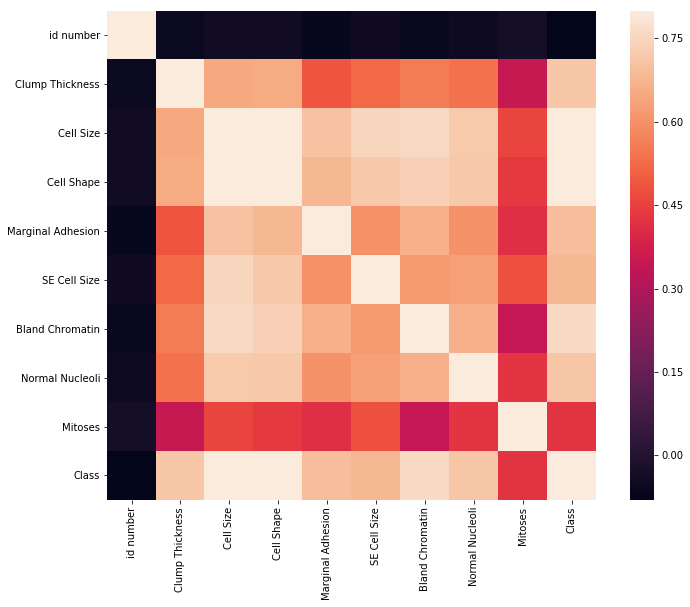

In [2]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sb.heatmap(corrmat, vmax=.8,square=True)
plt.show()

Right off the bat we can tell that there is a large amount co-linearity among some of the data points. This means there is room for us to do feature selection in order to reduce the run time on our model. This will help when we attempt to do models such as gradient boosting and random forest trees because we will not need to incorporate all of the features to maintain variance.

In [3]:
for i in data.columns:
    print(data[i].value_counts())

1182404    6
1276091    5
1198641    3
466906     2
1116116    2
1070935    2
385103     2
1293439    2
1240603    2
1277792    2
1168736    2
560680     2
1174057    2
822829     2
320675     2
897471     2
1114570    2
704097     2
1339781    2
654546     2
734111     2
1017023    2
1354840    2
411453     2
769612     2
1158247    2
1321942    2
1061990    2
733639     2
1218860    2
          ..
1096352    1
1171845    1
255644     1
1169049    1
1041043    1
1190546    1
1071760    1
797327     1
1293966    1
1214092    1
709287     1
432809     1
888523     1
1201834    1
1182410    1
640712     1
1018561    1
1336798    1
1091262    1
1173216    1
1286943    1
1319609    1
1172152    1
558538     1
1207986    1
1302428    1
857774     1
1181356    1
1125035    1
625201     1
Name: id number, Length: 644, dtype: int64
1     145
5     129
3     108
4      80
10     69
2      50
8      46
6      34
7      23
9      14
Name: Clump Thickness, dtype: int64
1     383
10     67
3      5

In [84]:
data['Class'] = data['Class'].apply(lambda x: 0 if x==2 else 1)
print(data['Class'].value_counts())
data['Bare Nuclei'] = data['Bare Nuclei'].apply(lambda x: 11 if x == "?" else x)
print(data['Bare Nuclei'].value_counts())

2    457
4    241
Name: Class, dtype: int64
0    457
1    241
Name: Class, dtype: int64
1     401
10    132
2      30
5      30
3      28
8      21
4      19
11     16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64


Bare Nuclei has a "?" value, so we will need to get rid of that before we can proceed with resampling and modeling. From this we can also observe that sometimes the same patient is tested multiple times, and that we will need to resample. 

No Cancer: 457
Cancer: 241
Proportion: 1.9 : 1


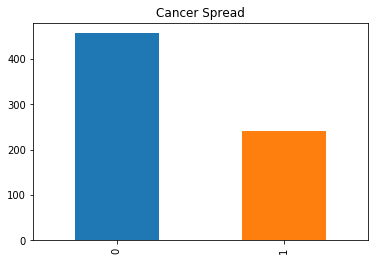

In [86]:
#Create a var graog that displays the number of class 0 and 1s in our data set
class_size = data.Class.value_counts()
print('No Cancer:', class_size[0])
print('Cancer:', class_size[1])
print('Proportion:', round(class_size[0] / class_size[1], 2), ': 1')

class_size.plot(kind='bar', title='Cancer Spread');

Here we are evaluating how skewed our data is in terms of data that have no cancer and cancer. There is roughly double the amount of no cancer vs cancer examples and thus we will need to perform resampling before we attempt to model.

# Resample

In [88]:
from sklearn.utils import resample
# Separate majority and minority classes
data_majority = data[data.Class==0]
data_minority = data[data.Class==1]
 
# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=457)    # to match majority class
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
data_upsampled.Class.value_counts()

1    457
0    457
Name: Class, dtype: int64

# Create X/Y

In [7]:
#Create our target and data set
target = data_upsampled.Class.copy()
selected_data = data_upsampled.drop(['Class','id number'], axis=1)

# Feature Selection: Select K Best

In [8]:
#Use Select K Best after using PCA to determine the number of dimensions to achieve the 2 features that have the greatest variance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=4)
selector.fit(selected_data, target)

X_new = selector.transform(selected_data)
print(X_new.shape)

selected_data.columns[selector.get_support(indices=True)]
selected_data.columns[selector.get_support(indices=True)].tolist()
#sets newdata to only contain the two features that will give us the most variance
skb_data = selected_data[selected_data.columns[selector.get_support(indices=True)].tolist()].copy()
skb_data.head(10)

(914, 4)


,Cell Size,Cell Shape,Bare Nuclei,Normal Nucleoli
0,4,4,10,2
1,1,1,2,1
2,8,8,4,7
3,1,1,1,1
5,1,1,10,1
6,1,2,1,1
7,1,1,1,1
8,2,1,1,1
9,1,1,1,1
10,1,1,1,1


# Feature Selection: PCA

In [9]:
from sklearn.decomposition import PCA
#Here we are setting pca to be fitted with n_components = 2, this is because after the 2 largest variables the amount of variance
#increase is much less significant
pca = PCA(n_components=4)
pca_data = pca.fit_transform(selected_data) 

print(pca.explained_variance_ratio_) #Shows how much variance the first and second dimensional space has
print(pca.explained_variance_ratio_.cumsum())  #Shows that with n_components=2, I retain .98% of the variance cumaltively

[0.64150064 0.09780001 0.06697122 0.05435625]
[0.64150064 0.73930065 0.80627186 0.86062811]


# Create Training and Test Set

In [10]:
#Create our testing and training data set, with spread of 70% in training and 30% in testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_data, target, test_size=0.3, random_state=20)
sX_train, sX_test, sy_train, sy_test = train_test_split(skb_data, target, test_size=0.3, random_state=20)
pX_train, pX_test, py_train, py_test = train_test_split(pca_data, target, test_size=0.3, random_state=20)

# Random Decision Tree: No Feature Selection

In [11]:
import time

start_time = time.time()
reset_time = time.time() - start_time

import warnings
warnings.filterwarnings("ignore")

from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 2 ,
    n_estimators = 2,
    n_jobs=-1
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_sr.fit(X_train, y_train)  
best_result = gd_sr.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.9765258215962441
--- 34.551259994506836 seconds ---


In [12]:
model_name = gd_sr
print('With 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, selected_data, target, cv=10))

prediction = model_name.predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(y_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

With 20% Holdout: 0.9418181818181818
Testing on Sample: 0.9693654266958425

 Cross Validation
[0.92391304 0.97826087 0.93478261 0.92391304 0.95652174 0.94565217
 1.         0.98888889 0.98888889 0.98888889]

 Confusion Matrix
[[141   9]
 [  0 125]]

 Classification Report
              precision    recall  f1-score   support

           2       1.00      0.94      0.97       150
           4       0.93      1.00      0.97       125

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275


 Roc Auc Score
0.97
--- 439.5742235183716 seconds ---


# Random Decision Tree: Select K Best

In [13]:
from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 2 ,
    n_estimators = 2,
    n_jobs=-1
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
skb_gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

skb_gd_sr.fit(sX_train, sy_train)  
best_result = skb_gd_sr.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.971830985915493
--- 42.25921893119812 seconds ---


In [14]:
model_name = skb_gd_sr

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, skb_data, target, cv=10))

prediction = model_name.predict(sX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(sy_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(sy_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(sy_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.91304348 0.9673913  0.95652174 0.92391304 0.94565217 0.95652174
 0.97826087 0.98888889 0.95555556 0.98888889]

 Confusion Matrix
[[141   9]
 [  3 122]]

 Classification Report
              precision    recall  f1-score   support

           2       0.98      0.94      0.96       150
           4       0.93      0.98      0.95       125

   micro avg       0.96      0.96      0.96       275
   macro avg       0.96      0.96      0.96       275
weighted avg       0.96      0.96      0.96       275


 Roc Auc Score
0.958
--- 351.1043915748596 seconds ---


# Random Decision Tree: PCA

In [15]:
from sklearn import ensemble
#Create a generic random forest tree
rfc = ensemble.RandomForestClassifier(
    criterion='entropy',
    max_features = 'auto',
    max_depth = 2 ,
    n_estimators = 2,
    n_jobs=-1
    )

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
pca_gd_sr = GridSearchCV(estimator=rfc,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

pca_gd_sr.fit(pX_train, py_train)  
best_result = pca_gd_sr.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.9780907668231612
--- 31.914457082748413 seconds ---


In [16]:
model_name = pca_gd_sr

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, pca_data, target, cv=10))

prediction = model_name.predict(pX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(py_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(py_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(py_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.95652174 1.         0.9673913  0.93478261 0.98913043 0.97826087
 0.92391304 1.         1.         0.98888889]

 Confusion Matrix
[[145   5]
 [  1 124]]

 Classification Report
              precision    recall  f1-score   support

           2       0.99      0.97      0.98       150
           4       0.96      0.99      0.98       125

   micro avg       0.98      0.98      0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275


 Roc Auc Score
0.9793333333333333
--- 278.9342155456543 seconds ---


# Logistic Regression: No Feature Selection

In [17]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
# Set up the regression model to predict defaults using all other
# variables as features.
regr = LogisticRegression(solver='lbfgs')
regrfit = regr.fit(X_train, y_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = regrfit.predict(X_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(y_train, pred_y_statsmod)

print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 0.02300548553466797 seconds ---


In [18]:
import warnings
warnings.filterwarnings("ignore")

model_name = regr
print('With 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, selected_data, target, cv=10))

prediction = model_name.predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(y_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

With 20% Holdout: 0.96
Testing on Sample: 0.9704595185995624

 Cross Validation
[0.92391304 1.         0.93478261 0.93478261 0.97826087 0.97826087
 0.95652174 0.98888889 0.97777778 0.98888889]

 Confusion Matrix
[[146   4]
 [  4 121]]

 Classification Report
              precision    recall  f1-score   support

           2       0.97      0.97      0.97       150
           4       0.97      0.97      0.97       125

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275


 Roc Auc Score
0.9706666666666667
--- 0.12402844429016113 seconds ---


# Logistic Regression: SKB

In [43]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
# Set up the regression model to predict defaults using all other
# variables as features.
skbregr = LogisticRegression(solver='lbfgs')
skbregrfit = skbregr.fit(sX_train, sy_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = skbregrfit.predict(sX_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(sy_train, pred_y_statsmod)
print(table)

print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

col_0    1
Class     
2      307
4      332
--- 88.07062363624573 seconds ---


In [44]:
model_name = skbregr

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, skb_data, target, cv=10))

prediction = model_name.predict(sX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(sy_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(sy_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(sy_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.93478261 0.98913043 0.92391304 0.86956522 0.9673913  0.95652174
 0.98913043 0.97777778 0.98888889 0.97777778]

 Confusion Matrix
[[144   6]
 [  5 120]]

 Classification Report
              precision    recall  f1-score   support

           2       0.97      0.96      0.96       150
           4       0.95      0.96      0.96       125

   micro avg       0.96      0.96      0.96       275
   macro avg       0.96      0.96      0.96       275
weighted avg       0.96      0.96      0.96       275


 Roc Auc Score
0.96
--- 1.8948633670806885 seconds ---


# Logistic Regression: PCA

In [22]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
# Set up the regression model to predict defaults using all other
# variables as features.
pcaregr = LogisticRegression(solver='lbfgs')
pcaregrfit = pcaregr.fit(pX_train, py_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = pcaregrfit.predict(pX_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(py_train, pred_y_statsmod)
print(table)

print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

col_0    1
Class     
2      307
4      332
--- 33.403879165649414 seconds ---


In [41]:
model_name = pcaregr

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, pca_data, target, cv=10))

prediction = model_name.predict(pX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(py_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(py_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(py_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.92391304 1.         0.93478261 0.92391304 0.98913043 0.97826087
 0.9673913  0.98888889 0.98888889 0.97777778]

 Confusion Matrix
[[145   5]
 [  4 121]]

 Classification Report
              precision    recall  f1-score   support

           2       0.97      0.97      0.97       150
           4       0.96      0.97      0.96       125

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275


 Roc Auc Score
0.9673333333333334
--- 43.99524784088135 seconds ---


# Gradient Boosting: Regular

In [34]:
params = {'n_estimators': 10,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
}
gd_clf = GridSearchCV(estimator=clf,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

gd_clf.fit(X_train, y_train)  
best_result = gd_clf.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.9765258215962441
--- 39.17125391960144 seconds ---


In [35]:
import warnings
warnings.filterwarnings("ignore")

model_name = gd_clf
print('With 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, selected_data, target, cv=10))

prediction = model_name.predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(y_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

With 20% Holdout: 0.9781818181818182
Testing on Sample: 0.9792122538293216

 Cross Validation
[0.95652174 0.98913043 0.97826087 0.93478261 0.95652174 0.98913043
 1.         1.         0.98888889 0.98888889]

 Confusion Matrix
[[145   5]
 [  0 125]]

 Classification Report
              precision    recall  f1-score   support

           2       1.00      0.97      0.98       150
           4       0.96      1.00      0.98       125

   micro avg       0.98      0.98      0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275


 Roc Auc Score
0.9833333333333334
--- 6.02235746383667 seconds ---


# Gradient Boosting: Select K Best

In [37]:
params = {'n_estimators': 10,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
skbclf = ensemble.GradientBoostingClassifier(**params)
skbclf.fit(sX_train, sy_train)

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
}
sgd_clf = GridSearchCV(estimator=skbclf,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

sgd_clf.fit(sX_train, sy_train)  
best_result = sgd_clf.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.974960876369327
--- 82.63614130020142 seconds ---


In [38]:
import warnings
warnings.filterwarnings("ignore")

model_name = sgd_clf
from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, skb_data, target, cv=10))

prediction = model_name.predict(sX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(sy_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(sy_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(sy_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.95652174 0.97826087 0.95652174 0.92391304 0.9673913  0.9673913
 1.         0.98888889 0.96666667 0.98888889]

 Confusion Matrix
[[143   7]
 [  3 122]]

 Classification Report
              precision    recall  f1-score   support

           2       0.98      0.95      0.97       150
           4       0.95      0.98      0.96       125

   micro avg       0.96      0.96      0.96       275
   macro avg       0.96      0.96      0.96       275
weighted avg       0.96      0.96      0.96       275


 Roc Auc Score
0.9646666666666667
--- 773.1918811798096 seconds ---


# Gradient Boosting: PCA

In [40]:
params = {'n_estimators': 10,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
pcaclf = ensemble.GradientBoostingClassifier(**params)
pcaclf.fit(sX_train, sy_train)

from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2, 3],
}
pca_clf = GridSearchCV(estimator=pcaclf,  
                     param_grid=parameters,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

pca_clf.fit(sX_train, sy_train)  
best_result = sgd_clf.best_score_  
print("Best Accuracy: ", best_result)  
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Best Accuracy:  0.974960876369327
--- 92.69249606132507 seconds ---


In [45]:
model_name = pca_clf

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, pca_data, target, cv=10))

prediction = model_name.predict(pX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(py_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(py_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(py_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.95652174 0.98913043 0.95652174 0.93478261 0.98913043 0.97826087
 0.98913043 0.98888889 1.         0.98888889]

 Confusion Matrix
[[149   1]
 [ 34  91]]

 Classification Report
              precision    recall  f1-score   support

           2       0.81      0.99      0.89       150
           4       0.99      0.73      0.84       125

   micro avg       0.87      0.87      0.87       275
   macro avg       0.90      0.86      0.87       275
weighted avg       0.89      0.87      0.87       275


 Roc Auc Score
0.8606666666666667
--- 46.18616557121277 seconds ---


# Ridge Regression : Regular 

In [97]:
ridgeregr = linear_model.Ridge(alpha=500, fit_intercept=False) 
ridgeregrfit = ridgeregr.fit(X_train, y_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = ridgeregrfit.predict(X_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
ridgetable = pd.crosstab(y_train, pred_y_statsmod)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 22.46206521987915 seconds ---


In [98]:
import warnings
warnings.filterwarnings("ignore")

print('Ridge Regression Score')
print(ridgeregrfit.score(X_test, y_test))

model_name = ridgeregr
print('\nWith 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

print('\n Accuracy by admission status')
print(ridgetable)

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Ridge Regression Score
0.3078988236704585

With 20% Holdout: 0.3078988236704585
Testing on Sample: 0.33184253632494864

 Accuracy by admission status
col_0    1
Class     
2      307
4      332

 Roc Auc Score
0.9898133333333333
--- 1.4663312435150146 seconds ---


# Ridge Regression: SKB

In [91]:
ridgeregr = linear_model.Ridge(alpha=500, fit_intercept=False) 
ridgeregrfit = ridgeregr.fit(sX_train, sy_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = ridgeregrfit.predict(sX_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
ridgetable = pd.crosstab(sy_train, pred_y_statsmod)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 4.643059968948364 seconds ---


In [92]:
import warnings
warnings.filterwarnings("ignore")

print('Ridge Regression Score')
print(ridgeregrfit.score(sX_test, sy_test))

model_name = ridgeregr
print('\nWith 20% Holdout: ' + str(model_name.fit(sX_train, sy_train).score(sX_test, sy_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

print('\n Accuracy by admission status')
print(ridgetable)

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Ridge Regression Score
-0.4094615074011265

With 20% Holdout: -0.4094615074011265
Testing on Sample: 0.33184253632494864

 Accuracy by admission status
col_0    1
Class     
2      307
4      332

 Roc Auc Score
0.9898133333333333
--- 1.4103174209594727 seconds ---


# Ridge Regression: PCA

In [89]:
ridgeregr = linear_model.Ridge(alpha=500, fit_intercept=False) 
ridgeregrfit = ridgeregr.fit(pX_train, py_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = ridgeregrfit.predict(pX_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
ridgetable = pd.crosstab(sy_train, pred_y_statsmod)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 1220.9424815177917 seconds ---


In [90]:
import warnings
warnings.filterwarnings("ignore")

print('Ridge Regression Score')
print(ridgeregrfit.score(pX_test, py_test))

model_name = ridgeregr
print('\nWith 20% Holdout: ' + str(model_name.fit(pX_train, py_train).score(pX_test, py_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

print('\n Accuracy by admission status')
print(ridgetable)

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Ridge Regression Score
-8.338396760696437

With 20% Holdout: -8.338396760696437
Testing on Sample: 0.33184253632494864

 Accuracy by admission status
col_0    0    1
Class          
2      302    5
4       72  260

 Roc Auc Score
0.9898133333333333
--- 1.13726806640625 seconds ---


# Lasso Regression: Regular

In [95]:
lassregr = linear_model.Lasso(alpha=.35)
lassregrfit = lassregr.fit(X_train, y_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = lassregrfit.predict(X_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
lasstable = pd.crosstab(y_train, pred_y_statsmod)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 678.8802919387817 seconds ---


In [96]:
import warnings
warnings.filterwarnings("ignore")

print('Lasso Regression Score')
print(lassregrfit.score(X_test, y_test))

model_name = lassregr
print('\nWith 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

print('\n Accuracy by admission status')
print(lasstable)

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Lasso Regression Score
0.7989369118844419

With 20% Holdout: 0.7989369118844419
Testing on Sample: 0.7793611238173326

 Accuracy by admission status
col_0    1
Class     
2      307
4      332

 Roc Auc Score
0.9898133333333333
--- 2.7346177101135254 seconds ---


# Lasso Regression: SKB

In [99]:
lassregr = linear_model.Lasso(alpha=.35)
lassregrfit = lassregr.fit(sX_train, sy_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = lassregrfit.predict(sX_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
lasstable = pd.crosstab(sy_train, pred_y_statsmod)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 2158.731187582016 seconds ---


In [100]:
import warnings
warnings.filterwarnings("ignore")

print('Lasso Regression Score')
print(lassregrfit.score(sX_test, sy_test))

model_name = lassregr
print('\nWith 20% Holdout: ' + str(model_name.fit(sX_train, sy_train).score(sX_test, sy_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

print('\n Accuracy by admission status')
print(lasstable)

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Lasso Regression Score
0.7614259402331588

With 20% Holdout: 0.7614259402331588
Testing on Sample: 0.7793611238173326

 Accuracy by admission status
col_0    1
Class     
2      307
4      332

 Roc Auc Score
0.9898133333333333
--- 1.319289207458496 seconds ---


# Lasso Regression: PCA

In [101]:
lassregr = linear_model.Lasso(alpha=.35)
lassregrfit = lassregr.fit(pX_train, py_train)

# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = lassregrfit.predict(pX_train)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
lasstable = pd.crosstab(py_train, pred_y_statsmod)
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

--- 57.0998911857605 seconds ---


In [102]:
import warnings
warnings.filterwarnings("ignore")

print('Lasso Regression Score')
print(lassregrfit.score(pX_test, py_test))

model_name = lassregr
print('\nWith 20% Holdout: ' + str(model_name.fit(pX_train, py_train).score(pX_test, py_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

print('\n Accuracy by admission status')
print(lasstable)

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

Lasso Regression Score
0.8050113088179783

With 20% Holdout: 0.8050113088179783
Testing on Sample: 0.7793611238173326

 Accuracy by admission status
col_0    1
Class     
2      307
4      332

 Roc Auc Score
0.9898133333333333
--- 1.2272851467132568 seconds ---


# SVM: Regular

In [103]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [105]:
model_name = svclassifier
print('With 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, selected_data, target, cv=10))

prediction = model_name.predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(y_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

With 20% Holdout: 0.9672727272727273
Testing on Sample: 0.9715536105032823

 Cross Validation
[0.93478261 0.98913043 0.95652174 0.93478261 0.98913043 0.97826087
 0.9673913  0.98888889 0.97777778 0.97777778]

 Confusion Matrix
[[145   5]
 [  3 122]]

 Classification Report
              precision    recall  f1-score   support

           2       0.98      0.97      0.97       150
           4       0.96      0.98      0.97       125

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275


 Roc Auc Score
0.9713333333333333
--- 93.50570130348206 seconds ---


# SVM: Select K Best

In [112]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')
svclassifier.fit(sX_train, sy_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [113]:
model_name = svclassifier

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, skb_data, target, cv=10))

prediction = model_name.predict(sX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(sy_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(sy_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(sy_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.93478261 0.98913043 0.92391304 0.89130435 0.97826087 0.94565217
 1.         0.97777778 1.         0.98888889]

 Confusion Matrix
[[144   6]
 [  3 122]]

 Classification Report
              precision    recall  f1-score   support

           2       0.98      0.96      0.97       150
           4       0.95      0.98      0.96       125

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275


 Roc Auc Score
0.968
--- 55.937424659729004 seconds ---


# SVM: PCA

In [114]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')
svclassifier.fit(pX_train, py_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [116]:
model_name = svclassifier

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, pca_data, target, cv=10))

prediction = model_name.predict(pX_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(py_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(py_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(py_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time


 Cross Validation
[0.93478261 0.98913043 0.95652174 0.93478261 0.98913043 0.97826087
 0.98913043 0.98888889 0.97777778 0.97777778]

 Confusion Matrix
[[145   5]
 [  3 122]]

 Classification Report
              precision    recall  f1-score   support

           2       0.98      0.97      0.97       150
           4       0.96      0.98      0.97       125

   micro avg       0.97      0.97      0.97       275
   macro avg       0.97      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275


 Roc Auc Score
0.9713333333333333
--- 24.223003387451172 seconds ---


# KNN Classifier: Regular

In [118]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform')

In [123]:
model_name = knn
print('With 20% Holdout: ' + str(model_name.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(model_name.fit(selected_data, target).score(selected_data, target)))

from sklearn.model_selection import cross_val_score 
print('\n Cross Validation')
print(cross_val_score(model_name, selected_data, target, cv=10))

prediction = model_name.predict(X_test)
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, prediction)
print('\n Confusion Matrix')
print(cnf_matrix)

from sklearn.metrics import classification_report
print('\n Classification Report')
print(classification_report(y_test, prediction))

from sklearn.metrics import roc_auc_score
print('\n Roc Auc Score')
print(roc_auc_score(y_test, prediction))
print("--- %s seconds ---" % (time.time() - start_time - reset_time))
reset_time = time.time() - start_time

With 20% Holdout: 0.9269659863945579
Testing on Sample: 0.9394453623900325

 Cross Validation
[0.         0.         0.         0.         0.64526485 0.
 0.         0.         0.         0.        ]


ValueError: Classification metrics can't handle a mix of binary and continuous targets